In [2]:
!nvidia-smi

Mon Feb  5 12:51:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          On  | 00000001:00:00.0 Off |                    0 |
| N/A   55C    P0              78W / 300W |  63960MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
from modeling import MM_LLMs, MM_LLMs_Config
from transformers import CLIPProcessor, CLIPModel,AutoModel, AutoTokenizer, AutoProcessor,AutoConfig,CLIPConfig, LlamaConfig, WhisperConfig, WhisperModel, LlamaModel, LlamaTokenizer
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from processing_multimodal import MMProcessor
import torch
import numpy as np
from torch import nn
from streaming import LocalDataset
from typing import List

In [5]:
!ls multimodal-tinyllama-whisper-small-siglip-v1

checkpoint-800	checkpoint-900


In [6]:
model = MM_LLMs.from_pretrained(
    'multimodal-tinyllama-whisper-small-siglip-v1/checkpoint-900',
    use_flash_attention_2 = True,
    torch_dtype = torch.bfloat16
)

The model was loaded with use_flash_attention_2=True, which is deprecated and may be removed in a future release. Please use `attn_implementation="flash_attention_2"` instead.
You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


In [7]:
_ = model.cuda()

In [8]:
image_processor = AutoProcessor.from_pretrained('google/siglip-base-patch16-224')
audio_processor = AutoProcessor.from_pretrained('mesolitica/malaysian-whisper-small')
tokenizer = AutoTokenizer.from_pretrained('multimodal-tinyllama-whisper-small-siglip-v1/checkpoint-900')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
from PIL import Image
import librosa
import torch
import numpy as np
from collections.abc import Mapping

class DataCollator():

    def __init__(self, tokenizer):

        self.tokenizer = tokenizer

    def __call__(self, features):

        if not isinstance(features[0], Mapping):
            features = [vars(f) for f in features]

        batch = {}
        bs = len(features)
        first = features[0]

        batch['audio_index'] = torch.tensor([],dtype=torch.int)
        batch['image_index'] = torch.tensor([],dtype=torch.int)
        
        for index, feature in enumerate(features):
            local_index = index % (bs // torch.cuda.device_count()) if bs > 1 else index % (bs) 
            if feature['audios'] is not None:
                batch['audio_index'] = torch.cat([batch['audio_index'], torch.tensor([local_index] * len(feature['audios']), dtype=torch.int)])

            if feature['images'] is not None:
                batch['image_index'] = torch.cat([batch['image_index'], torch.tensor([local_index] * len(feature['images']), dtype=torch.int)])

        for k, v in first.items():

            if k not in ("audios","images") and not isinstance(v, str):
                if v is None:
                    batch[k] = None
                elif isinstance(v, torch.Tensor):
                    batch[k] = torch.stack([f[k] for f in features]).squeeze(1)
                elif isinstance(v, np.ndarray):
                    batch[k] = torch.tensor(np.stack([f[k] for f in features])).squeeze(1)
            elif k in ("audios","images"):
                if v is None:
                    batch[k] = None
                else:         
                    batch[k] = torch.cat([f[k] for f in features if f[k] is not None])

        batch['image_starts'] = torch.tensor([self.tokenizer.convert_tokens_to_ids('<image>')] * bs, dtype=torch.int)
        batch['image_ends'] = torch.tensor([self.tokenizer.convert_tokens_to_ids('</image>')] * bs, dtype=torch.int)
        batch['audio_starts'] = torch.tensor([self.tokenizer.convert_tokens_to_ids('<audio>')] * bs, dtype=torch.int)
        batch['audio_ends'] = torch.tensor([self.tokenizer.convert_tokens_to_ids('</audio>')] * bs, dtype=torch.int)

        return batch

collator = DataCollator(tokenizer)

In [10]:
def prepare_dataset(messages, images: List[str] = None, audio: List[str] = None, sr: int = 16000):
    if images is not None:
        images = [Image.open(f) for f in images]
    else:
        images = np.zeros((1, 3, 224, 224))
    image_output = image_processor(images=images, return_tensors='pt')['pixel_values']
    
    if audio is not None:
        audio = [librosa.load(f, sr=sr)[0] for f in audio]
    else:
        audio = np.zeros((sr * 10,))
    audio_features = audio_processor(audio, sampling_rate=sr, return_tensors='pt',)['input_features']
    prompt = tokenizer.apply_chat_template(messages, tokenize = False)
    outputs = tokenizer(
                    prompt,
                    return_tensors='pt',
                    return_overflowing_tokens=False,
                    return_length=False)

    outputs['audios'] = audio_features
    outputs['images'] = image_output
    return outputs

In [46]:
messages = [
    {'role': 'user', 'content': '<image> apa yang saya boleh buat dengan ni'},
]
outputs = prepare_dataset(messages, ['motosikal.jpeg'])
ok = collator([outputs])

for k in ok.keys():
    if ok[k] is not None:
        ok[k] = ok[k].cuda()
        
for k in ['audios', 'images']:
    if ok[k] is not None:
        ok[k] = ok[k].type(model.dtype)

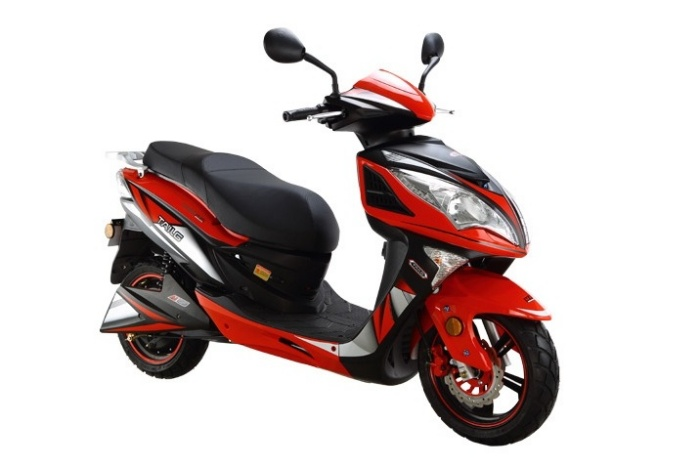

In [47]:
Image.open('motosikal.jpeg')

In [48]:
with torch.no_grad():
    model_inputs = model.prepare_inputs_for_generation(**ok)
model_inputs.pop('input_ids', None)

tensor([[    1,   518, 25580, 29962, 32000,  3095, 29874,   343,   574,  1827,
         29874,  1045,   280, 29882,  1321,   271,   972,  6249,  6836,   518,
         29914, 25580, 29962]], device='cuda:0')

In [49]:
ok['input_ids'].shape, model_inputs['inputs_embeds'].shape

(torch.Size([1, 23]), torch.Size([1, 36, 2048]))

In [50]:
generate_kwargs = dict(
    model_inputs,
    max_new_tokens=300,
    top_p=0.95,
    top_k=50,
    temperature=0.1,
    do_sample=True,
    num_beams=1,
    eos_token_id=model.llm.config.eos_token_id,
    bos_token_id=model.llm.config.bos_token_id,
    pad_token_id=model.llm.config.pad_token_id
)

r = model.llm.generate(**generate_kwargs)
tokenizer.decode(r[0])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


'<s>Dengan banyak kepingan kek cawan yang kelihatan di atas meja, saya boleh mencuba pelbagai resipi kek cawan yang berbeza untuk mencari kegemaran saya. Saya boleh mencuba resipi yang berbeza, seperti kek cawan vanila, kek cawan coklat, kek cawan coklat muda atau kek cawan berasaskan kopi. Saya juga boleh mencuba resipi yang berbeza, seperti kek cawan yang dibuat dengan tepung, gula serbuk, susu dan vanila, atau kek cawan yang dibuat dengan tepung, gula serbuk, susu dan serbuk penaik.\n\nSelain itu, saya boleh mencuba resipi kek cawan yang berbeza, seperti kek cawan yang dibuat dengan tepung, gula serbuk, susu dan vanila, atau kek cawan yang dibuat dengan tepung, gula serbuk, susu dan serbuk p'

In [ ]:
model.push_to_hub('malaysian-tinyllama-multimodal', organization='mesolitica', safe_serialization=True)

/home/ubuntu/.local/lib/python3.10/site-packages/transformers/utils/hub.py:667: UserWarning: The `organization` argument is deprecated and will be removed in v5 of Transformers. Set your organization directly in the `repo_id` passed instead (`repo_id={organization}/{model_id}`).
  warnings.warn(


model.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

In [ ]:
image_processor.push_to_hub('malaysian-tinyllama-multimodal', organization='mesolitica', safe_serialization=True)

In [ ]:
audio_processor.push_to_hub('malaysian-tinyllama-multimodal', organization='mesolitica', safe_serialization=True)

In [ ]:
tokenizer.push_to_hub('malaysian-tinyllama-multimodal', organization='mesolitica', safe_serialization=True)